# Synthcity PoC for diabetes dataset

Using [Diabetes dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) for exploring very simple single table mock data use case.

### Requirements

As a **data engineer**, I should be able to specify what is already public to the data scientist and include only that information to the mock dataset.
Let's specify **public data** for diabetes dataset:
* Pregnancies: integer, mean 3.8
* Age: integer, between 18 and 100
* Outcome: boolean (0, 1), 35% true (1)
* Other columns should be dropped

### synthcity features used
* Bayesian network model
* Constraints for specifying the age range
* Conditionals for specifying the outcome distribution

### synthcity features **not** used
* Custom plugins

### Diabetes data

In [87]:
import pandas as pd

df = pd.read_csv("../datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [88]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [89]:
from synthcity.plugins.core.dataloader import GenericDataLoader

loader = GenericDataLoader(
    df,
    target_column="Outcome"
)

loader = loader.drop(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction'])
loader.dataframe().head()

,Pregnancies,Age,Outcome
0,6,50,1
1,1,31,0
2,8,32,1
3,1,21,0
4,0,33,1


In [90]:
from synthcity.plugins.core.constraints import Constraints

age_constraints = Constraints(rules=[('Age', '>=', 18), ('Age', '<=', 100)])
loader = loader.match(age_constraints)

### Create model

In [91]:
from synthcity.plugins import Plugins

eval_plugin = "bayesian_network"
syn_model = Plugins().get(eval_plugin)
syn_model.fit(loader, cond=df['Outcome'].to_frame())

### Generate data using conditionals

Use binomial distribution conditional for specifying the outcome distribution.

In [92]:
import numpy as np
num_rows = 100
rng = np.random.default_rng()
outcome_distribution = rng.binomial(num_rows, 0.35)

generated_data = syn_model.generate(count=num_rows, cond=outcome_distribution)

In [93]:
assert generated_data.shape[1] == 3
generated_data.dataframe().head()

,Pregnancies,Age,Outcome
0,4,31,0
1,8,39,0
2,4,31,1
3,6,30,1
4,1,25,0


### Evaluate

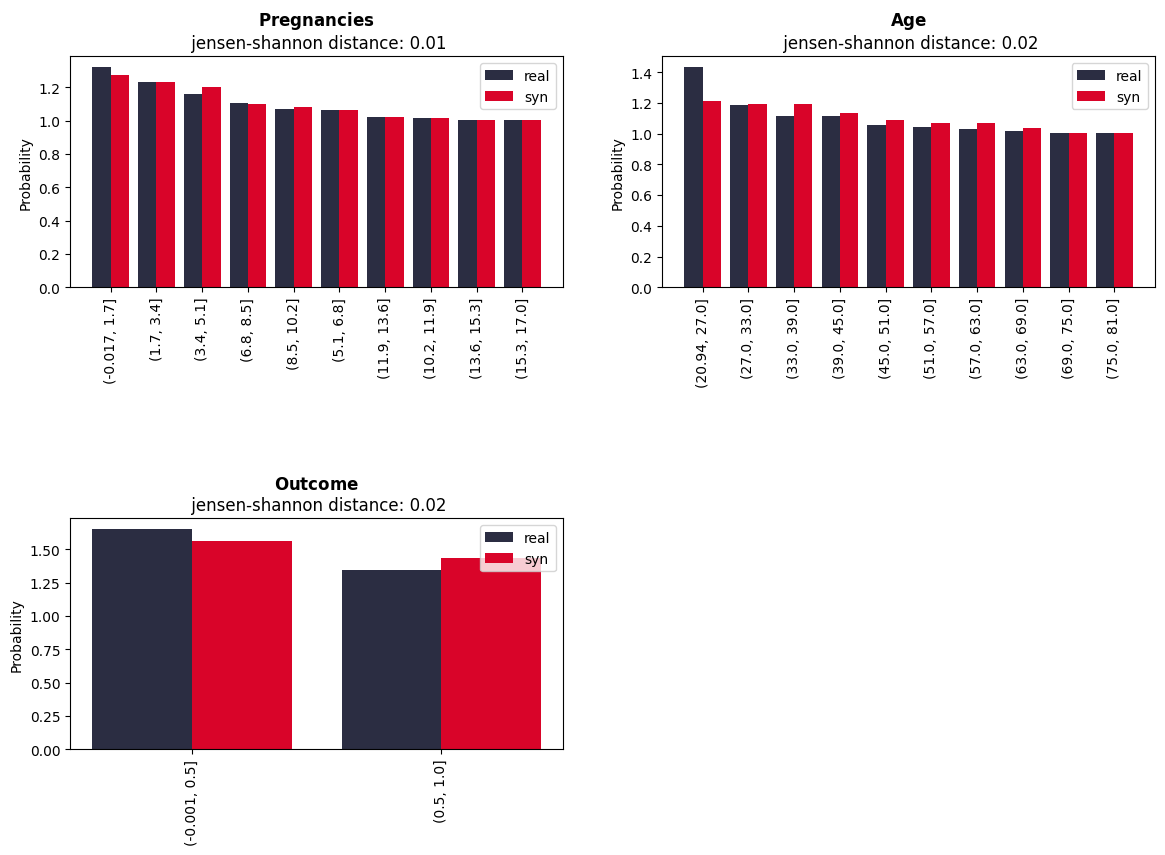

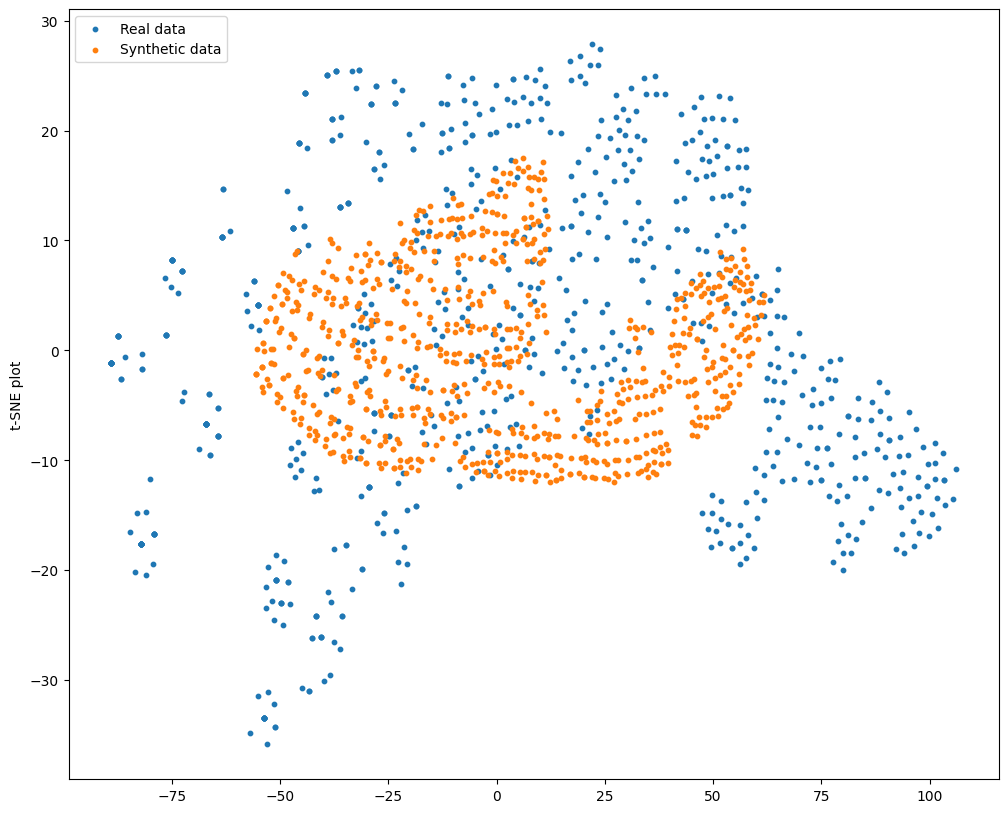

In [94]:
import matplotlib.pyplot as plt

syn_model.plot(plt, loader)
plt.show()

In [95]:
from synthcity.benchmark import Benchmarks

score = Benchmarks.evaluate(
    [(eval_plugin, eval_plugin, {})],
    loader,
    repeats=2
)

In [96]:
Benchmarks.print(score)


Plugin : bayesian_network


,min,max,mean,stddev,median,iqr,rounds,errors,durations
sanity.data_mismatch.score,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0,0.00
sanity.common_rows_proportion.score,0.302932,0.319218,0.311075,0.008143,0.311075,0.008143,2,0,0.00
sanity.nearest_syn_neighbor_distance.mean,0.066726,0.072258,0.069492,0.002766,0.069492,0.002766,2,0,0.00
sanity.close_values_probability.score,0.923453,0.934853,0.929153,0.005700,0.929153,0.005700,2,0,0.00
sanity.distant_values_probability.score,0.001629,0.001629,0.001629,0.000000,0.001629,0.000000,2,0,0.00
stats.jensenshannon_dist.marginal,0.013457,0.017020,0.015239,0.001782,0.015239,0.001782,2,0,0.00
stats.chi_squared_test.marginal,0.615639,0.965867,0.790753,0.175114,0.790753,0.175114,2,0,0.00
stats.inv_kl_divergence.marginal,0.935193,0.953811,0.944502,0.009309,0.944502,0.009309,2,0,0.00
stats.ks_test.marginal,0.865364,0.882193,0.873779,0.008415,0.873779,0.008415,2,0,0.00
stats.max_mean_discrepancy.joint,0.010426,0.010531,0.010479,0.001000,0.010479,0.000052,2,0,0.00


### Pregnancies mean

In [98]:
print(f"Original data: {df['Pregnancies'].mean()}")
print(f"Generated data: {generated_data.dataframe()['Pregnancies'].mean()}")

Original data: 3.8450520833333335
Generated data: 3.33


### Conclusions

* synthcity is still in early stages
   * there are tutorials available but very little actual documentation
* No support for relational data
* Plugin architecture looks interesting, to be explored
* Requirements that were **not** met:
   * **mean** of the pregnancies could not be specified